# Methane Working Capacity prediction using Machine Learning 
    1.1 Import package
    1.2 Set variable
    2.1 Divid dataset(Diversity Selection) and Save divided dataset
    2.2 Load divided dataset
    2.3 Plot feature distribution 
    3.1 Train model(Gradient Boosting Regression) and Save training model
    3.2 Load feature importance from saved model
    3.3 Plot feature importances
    
## Necessary Process 1.1, 1.2, 2.2, 3.2


## 1.1 Import package

In [2]:
import random
import csv
import sys
import time
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser
home = expanduser("~")

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
#from sklearn.externals import joblib
import joblib
import pickle

## 1.2  Set variable

In [3]:
file_name='Methane_merge_AGSA'
data_file_name="./"+file_name+".csv" 
feature_num=6
diverse_ratio=0.8 # training set ratio, 
remaining_ratio=1-diverse_ratio # test set ratio
random.seed(40)
cases=['LNG_ANG','ANG','5bar','6bar','65bar']

## 2.1 Divid dataset (Diversity Selection) and Save divided dataset

In [29]:
with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        n_samples = int(temp[0])
        N_features = int(temp[1])
        if N_features != feature_num:
            print("N_features is not"+str(feature_num))
            sys.exit()
        data = np.empty((n_samples, N_features))
        temp = next(data_file)
        feature_list=temp[:N_features]
        for i, d in enumerate(data_file):
            data[i] = np.asarray(d[:feature_num], dtype=np.float64)
print("Total number of materials : ", data.shape[0])
N_materials = data.shape[0]


print("Number of features: ", N_features)
feature_0 = data.T[0]
feature_1 = data.T[1]
feature_2 = data.T[2]
feature_3 = data.T[3]
feature_4 = data.T[4]
feature_5 = data.T[5]
# rescale
feature_0 = (feature_0 - np.min(feature_0))/(np.max(feature_0) - np.min(feature_0))
feature_1 = (feature_1 - np.min(feature_1))/(np.max(feature_1) - np.min(feature_1))
feature_2 = (feature_2 - np.min(feature_2))/(np.max(feature_2) - np.min(feature_2))
feature_3 = (feature_3 - np.min(feature_3))/(np.max(feature_3) - np.min(feature_3))
feature_4 = (feature_4 - np.min(feature_4))/(np.max(feature_4) - np.min(feature_4))
feature_5 = (feature_5 - np.min(feature_5))/(np.max(feature_5) - np.min(feature_5))

if N_features == 5:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials)))
if N_features == 6:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials)))
if N_features == 7:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials),feature_6.reshape(1,N_materials)))
    
print("Shape of feature x: ", np.shape(x))
print("Example feature vector = " , x[:,0])
N_sample = int(N_materials * diverse_ratio)-1

print("Sampling %d diverse structures out of %d" % (N_sample+1,N_materials))
print("total accessible materials considered: ", N_materials)



print("Starting diversity selection. Seeking %d points" % (N_sample+1))
time.sleep(1)
# store indices of x here for the diverse and non-diverse sets.
diverse_set = []
remaining_set = list(range(N_materials))
# INITIALIZE WITH RANDOMLY SELECTED POINT
idx_init = random.sample(list(np.arange(N_materials)),1)[0]
diverse_set.append(idx_init)
remaining_set.remove(idx_init)
N_diverse = 1
while N_diverse <= N_sample:
        print("Selecting point ", N_diverse)
        min_d_to_diverse_set = np.zeros((N_materials-N_diverse,))
        # for every candidate point not in diverse set...
        for i in range(N_materials - N_diverse):
            # get the distance of this point to each point in the diverse set
            d_from_each_diverse_pt = np.linalg.norm(x[:,diverse_set] - x[:,remaining_set[i]].reshape(N_features,1),axis=0)
            # get the closest distance that this point is to the diverse set
            min_d_to_diverse_set[i] = np.min(d_from_each_diverse_pt)
        # select point that has the largest distance from the diverse set
        idx_select = remaining_set[np.argmax(min_d_to_diverse_set)]
        assert (len(remaining_set) == np.size(min_d_to_diverse_set))
        print("\tSelected point " , idx_select)
        # add point to diverse set; remove it from remaining set
        diverse_set.append(idx_select)
        remaining_set.remove(idx_select)
        print("\tPts in diverse set: ", len(diverse_set))
        print("\tPts in remaining set: ", len(remaining_set))
        print(diverse_set[N_diverse-1])
        N_diverse += 1

with open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(feature_num)+"_"+file_name+"feature.txt", "w") as f:
    f.write(str(diverse_set)+" "+str(remaining_set))
    print("Save file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(N_features)+"_"+file_name+"feature.txt")


Total number of materials :  6374
Number of features:  6
Shape of feature x:  (6, 6374)
Example feature vector =  [0.10930255 0.00874096 0.20207309 0.23267102 0.59577589 0.69222951]
Sampling 5099 diverse structures out of 6374
total accessible materials considered:  6374
Starting diversity selection. Seeking 5099 points
Selecting point  1
	Selected point  4374
	Pts in diverse set:  2
	Pts in remaining set:  6372
3756
Selecting point  2
	Selected point  2694
	Pts in diverse set:  3
	Pts in remaining set:  6371
4374
Selecting point  3
	Selected point  4866
	Pts in diverse set:  4
	Pts in remaining set:  6370
2694
Selecting point  4
	Selected point  309
	Pts in diverse set:  5
	Pts in remaining set:  6369
4866
Selecting point  5
	Selected point  207
	Pts in diverse set:  6
	Pts in remaining set:  6368
309
Selecting point  6
	Selected point  3073
	Pts in diverse set:  7
	Pts in remaining set:  6367
207
Selecting point  7
	Selected point  4372
	Pts in diverse set:  8
	Pts in remaining set: 

	Selected point  2809
	Pts in diverse set:  81
	Pts in remaining set:  6293
5966
Selecting point  81
	Selected point  3940
	Pts in diverse set:  82
	Pts in remaining set:  6292
2809
Selecting point  82
	Selected point  1581
	Pts in diverse set:  83
	Pts in remaining set:  6291
3940
Selecting point  83
	Selected point  2608
	Pts in diverse set:  84
	Pts in remaining set:  6290
1581
Selecting point  84
	Selected point  3451
	Pts in diverse set:  85
	Pts in remaining set:  6289
2608
Selecting point  85
	Selected point  3266
	Pts in diverse set:  86
	Pts in remaining set:  6288
3451
Selecting point  86
	Selected point  3083
	Pts in diverse set:  87
	Pts in remaining set:  6287
3266
Selecting point  87
	Selected point  349
	Pts in diverse set:  88
	Pts in remaining set:  6286
3083
Selecting point  88
	Selected point  5750
	Pts in diverse set:  89
	Pts in remaining set:  6285
349
Selecting point  89
	Selected point  316
	Pts in diverse set:  90
	Pts in remaining set:  6284
5750
Selecting poi

	Selected point  4898
	Pts in diverse set:  162
	Pts in remaining set:  6212
3115
Selecting point  162
	Selected point  5674
	Pts in diverse set:  163
	Pts in remaining set:  6211
4898
Selecting point  163
	Selected point  916
	Pts in diverse set:  164
	Pts in remaining set:  6210
5674
Selecting point  164
	Selected point  5995
	Pts in diverse set:  165
	Pts in remaining set:  6209
916
Selecting point  165
	Selected point  6091
	Pts in diverse set:  166
	Pts in remaining set:  6208
5995
Selecting point  166
	Selected point  1799
	Pts in diverse set:  167
	Pts in remaining set:  6207
6091
Selecting point  167
	Selected point  2903
	Pts in diverse set:  168
	Pts in remaining set:  6206
1799
Selecting point  168
	Selected point  157
	Pts in diverse set:  169
	Pts in remaining set:  6205
2903
Selecting point  169
	Selected point  1986
	Pts in diverse set:  170
	Pts in remaining set:  6204
157
Selecting point  170
	Selected point  5709
	Pts in diverse set:  171
	Pts in remaining set:  6203


	Selected point  1661
	Pts in diverse set:  242
	Pts in remaining set:  6132
227
Selecting point  242
	Selected point  2802
	Pts in diverse set:  243
	Pts in remaining set:  6131
1661
Selecting point  243
	Selected point  5992
	Pts in diverse set:  244
	Pts in remaining set:  6130
2802
Selecting point  244
	Selected point  520
	Pts in diverse set:  245
	Pts in remaining set:  6129
5992
Selecting point  245
	Selected point  1683
	Pts in diverse set:  246
	Pts in remaining set:  6128
520
Selecting point  246
	Selected point  315
	Pts in diverse set:  247
	Pts in remaining set:  6127
1683
Selecting point  247
	Selected point  3294
	Pts in diverse set:  248
	Pts in remaining set:  6126
315
Selecting point  248
	Selected point  5362
	Pts in diverse set:  249
	Pts in remaining set:  6125
3294
Selecting point  249
	Selected point  4719
	Pts in diverse set:  250
	Pts in remaining set:  6124
5362
Selecting point  250
	Selected point  2322
	Pts in diverse set:  251
	Pts in remaining set:  6123
4

	Selected point  3632
	Pts in diverse set:  322
	Pts in remaining set:  6052
2601
Selecting point  322
	Selected point  5014
	Pts in diverse set:  323
	Pts in remaining set:  6051
3632
Selecting point  323
	Selected point  1767
	Pts in diverse set:  324
	Pts in remaining set:  6050
5014
Selecting point  324
	Selected point  5229
	Pts in diverse set:  325
	Pts in remaining set:  6049
1767
Selecting point  325
	Selected point  3884
	Pts in diverse set:  326
	Pts in remaining set:  6048
5229
Selecting point  326
	Selected point  1997
	Pts in diverse set:  327
	Pts in remaining set:  6047
3884
Selecting point  327
	Selected point  4369
	Pts in diverse set:  328
	Pts in remaining set:  6046
1997
Selecting point  328
	Selected point  710
	Pts in diverse set:  329
	Pts in remaining set:  6045
4369
Selecting point  329
	Selected point  2640
	Pts in diverse set:  330
	Pts in remaining set:  6044
710
Selecting point  330
	Selected point  2637
	Pts in diverse set:  331
	Pts in remaining set:  604

	Selected point  5156
	Pts in diverse set:  402
	Pts in remaining set:  5972
4236
Selecting point  402
	Selected point  2772
	Pts in diverse set:  403
	Pts in remaining set:  5971
5156
Selecting point  403
	Selected point  2575
	Pts in diverse set:  404
	Pts in remaining set:  5970
2772
Selecting point  404
	Selected point  1689
	Pts in diverse set:  405
	Pts in remaining set:  5969
2575
Selecting point  405
	Selected point  4693
	Pts in diverse set:  406
	Pts in remaining set:  5968
1689
Selecting point  406
	Selected point  4657
	Pts in diverse set:  407
	Pts in remaining set:  5967
4693
Selecting point  407
	Selected point  5236
	Pts in diverse set:  408
	Pts in remaining set:  5966
4657
Selecting point  408
	Selected point  6212
	Pts in diverse set:  409
	Pts in remaining set:  5965
5236
Selecting point  409
	Selected point  4272
	Pts in diverse set:  410
	Pts in remaining set:  5964
6212
Selecting point  410
	Selected point  4452
	Pts in diverse set:  411
	Pts in remaining set:  5

	Selected point  2082
	Pts in diverse set:  482
	Pts in remaining set:  5892
717
Selecting point  482
	Selected point  2810
	Pts in diverse set:  483
	Pts in remaining set:  5891
2082
Selecting point  483
	Selected point  585
	Pts in diverse set:  484
	Pts in remaining set:  5890
2810
Selecting point  484
	Selected point  4244
	Pts in diverse set:  485
	Pts in remaining set:  5889
585
Selecting point  485
	Selected point  4523
	Pts in diverse set:  486
	Pts in remaining set:  5888
4244
Selecting point  486
	Selected point  1573
	Pts in diverse set:  487
	Pts in remaining set:  5887
4523
Selecting point  487
	Selected point  5429
	Pts in diverse set:  488
	Pts in remaining set:  5886
1573
Selecting point  488
	Selected point  1716
	Pts in diverse set:  489
	Pts in remaining set:  5885
5429
Selecting point  489
	Selected point  5903
	Pts in diverse set:  490
	Pts in remaining set:  5884
1716
Selecting point  490
	Selected point  5564
	Pts in diverse set:  491
	Pts in remaining set:  5883

	Selected point  625
	Pts in diverse set:  562
	Pts in remaining set:  5812
3970
Selecting point  562
	Selected point  5368
	Pts in diverse set:  563
	Pts in remaining set:  5811
625
Selecting point  563
	Selected point  2776
	Pts in diverse set:  564
	Pts in remaining set:  5810
5368
Selecting point  564
	Selected point  1414
	Pts in diverse set:  565
	Pts in remaining set:  5809
2776
Selecting point  565
	Selected point  4290
	Pts in diverse set:  566
	Pts in remaining set:  5808
1414
Selecting point  566
	Selected point  5891
	Pts in diverse set:  567
	Pts in remaining set:  5807
4290
Selecting point  567
	Selected point  5684
	Pts in diverse set:  568
	Pts in remaining set:  5806
5891
Selecting point  568
	Selected point  2975
	Pts in diverse set:  569
	Pts in remaining set:  5805
5684
Selecting point  569
	Selected point  6355
	Pts in diverse set:  570
	Pts in remaining set:  5804
2975
Selecting point  570
	Selected point  4781
	Pts in diverse set:  571
	Pts in remaining set:  580

	Selected point  404
	Pts in diverse set:  642
	Pts in remaining set:  5732
3185
Selecting point  642
	Selected point  5747
	Pts in diverse set:  643
	Pts in remaining set:  5731
404
Selecting point  643
	Selected point  5038
	Pts in diverse set:  644
	Pts in remaining set:  5730
5747
Selecting point  644
	Selected point  474
	Pts in diverse set:  645
	Pts in remaining set:  5729
5038
Selecting point  645
	Selected point  5359
	Pts in diverse set:  646
	Pts in remaining set:  5728
474
Selecting point  646
	Selected point  6226
	Pts in diverse set:  647
	Pts in remaining set:  5727
5359
Selecting point  647
	Selected point  515
	Pts in diverse set:  648
	Pts in remaining set:  5726
6226
Selecting point  648
	Selected point  3613
	Pts in diverse set:  649
	Pts in remaining set:  5725
515
Selecting point  649
	Selected point  4101
	Pts in diverse set:  650
	Pts in remaining set:  5724
3613
Selecting point  650
	Selected point  5841
	Pts in diverse set:  651
	Pts in remaining set:  5723
41

	Selected point  1164
	Pts in diverse set:  722
	Pts in remaining set:  5652
91
Selecting point  722
	Selected point  4190
	Pts in diverse set:  723
	Pts in remaining set:  5651
1164
Selecting point  723
	Selected point  6080
	Pts in diverse set:  724
	Pts in remaining set:  5650
4190
Selecting point  724
	Selected point  6298
	Pts in diverse set:  725
	Pts in remaining set:  5649
6080
Selecting point  725
	Selected point  4892
	Pts in diverse set:  726
	Pts in remaining set:  5648
6298
Selecting point  726
	Selected point  830
	Pts in diverse set:  727
	Pts in remaining set:  5647
4892
Selecting point  727
	Selected point  1405
	Pts in diverse set:  728
	Pts in remaining set:  5646
830
Selecting point  728
	Selected point  2959
	Pts in diverse set:  729
	Pts in remaining set:  5645
1405
Selecting point  729
	Selected point  4359
	Pts in diverse set:  730
	Pts in remaining set:  5644
2959
Selecting point  730
	Selected point  4298
	Pts in diverse set:  731
	Pts in remaining set:  5643


	Selected point  749
	Pts in diverse set:  802
	Pts in remaining set:  5572
202
Selecting point  802
	Selected point  3918
	Pts in diverse set:  803
	Pts in remaining set:  5571
749
Selecting point  803
	Selected point  235
	Pts in diverse set:  804
	Pts in remaining set:  5570
3918
Selecting point  804
	Selected point  2184
	Pts in diverse set:  805
	Pts in remaining set:  5569
235
Selecting point  805
	Selected point  6222
	Pts in diverse set:  806
	Pts in remaining set:  5568
2184
Selecting point  806
	Selected point  4224
	Pts in diverse set:  807
	Pts in remaining set:  5567
6222
Selecting point  807
	Selected point  1751
	Pts in diverse set:  808
	Pts in remaining set:  5566
4224
Selecting point  808
	Selected point  6335
	Pts in diverse set:  809
	Pts in remaining set:  5565
1751
Selecting point  809
	Selected point  4506
	Pts in diverse set:  810
	Pts in remaining set:  5564
6335
Selecting point  810
	Selected point  4754
	Pts in diverse set:  811
	Pts in remaining set:  5563
4

	Selected point  3505
	Pts in diverse set:  882
	Pts in remaining set:  5492
4338
Selecting point  882
	Selected point  6076
	Pts in diverse set:  883
	Pts in remaining set:  5491
3505
Selecting point  883
	Selected point  56
	Pts in diverse set:  884
	Pts in remaining set:  5490
6076
Selecting point  884
	Selected point  4925
	Pts in diverse set:  885
	Pts in remaining set:  5489
56
Selecting point  885
	Selected point  4263
	Pts in diverse set:  886
	Pts in remaining set:  5488
4925
Selecting point  886
	Selected point  1343
	Pts in diverse set:  887
	Pts in remaining set:  5487
4263
Selecting point  887
	Selected point  4928
	Pts in diverse set:  888
	Pts in remaining set:  5486
1343
Selecting point  888
	Selected point  1011
	Pts in diverse set:  889
	Pts in remaining set:  5485
4928
Selecting point  889
	Selected point  6342
	Pts in diverse set:  890
	Pts in remaining set:  5484
1011
Selecting point  890
	Selected point  1354
	Pts in diverse set:  891
	Pts in remaining set:  5483


	Selected point  5770
	Pts in diverse set:  962
	Pts in remaining set:  5412
4706
Selecting point  962
	Selected point  4638
	Pts in diverse set:  963
	Pts in remaining set:  5411
5770
Selecting point  963
	Selected point  3316
	Pts in diverse set:  964
	Pts in remaining set:  5410
4638
Selecting point  964
	Selected point  366
	Pts in diverse set:  965
	Pts in remaining set:  5409
3316
Selecting point  965
	Selected point  5725
	Pts in diverse set:  966
	Pts in remaining set:  5408
366
Selecting point  966
	Selected point  444
	Pts in diverse set:  967
	Pts in remaining set:  5407
5725
Selecting point  967
	Selected point  6282
	Pts in diverse set:  968
	Pts in remaining set:  5406
444
Selecting point  968
	Selected point  5234
	Pts in diverse set:  969
	Pts in remaining set:  5405
6282
Selecting point  969
	Selected point  2403
	Pts in diverse set:  970
	Pts in remaining set:  5404
5234
Selecting point  970
	Selected point  762
	Pts in diverse set:  971
	Pts in remaining set:  5403
2

	Selected point  5915
	Pts in diverse set:  1041
	Pts in remaining set:  5333
5340
Selecting point  1041
	Selected point  4169
	Pts in diverse set:  1042
	Pts in remaining set:  5332
5915
Selecting point  1042
	Selected point  4809
	Pts in diverse set:  1043
	Pts in remaining set:  5331
4169
Selecting point  1043
	Selected point  1043
	Pts in diverse set:  1044
	Pts in remaining set:  5330
4809
Selecting point  1044
	Selected point  3825
	Pts in diverse set:  1045
	Pts in remaining set:  5329
1043
Selecting point  1045
	Selected point  1918
	Pts in diverse set:  1046
	Pts in remaining set:  5328
3825
Selecting point  1046
	Selected point  4913
	Pts in diverse set:  1047
	Pts in remaining set:  5327
1918
Selecting point  1047
	Selected point  5493
	Pts in diverse set:  1048
	Pts in remaining set:  5326
4913
Selecting point  1048
	Selected point  1057
	Pts in diverse set:  1049
	Pts in remaining set:  5325
5493
Selecting point  1049
	Selected point  3434
	Pts in diverse set:  1050
	Pts i

	Selected point  3885
	Pts in diverse set:  1120
	Pts in remaining set:  5254
382
Selecting point  1120
	Selected point  2452
	Pts in diverse set:  1121
	Pts in remaining set:  5253
3885
Selecting point  1121
	Selected point  5400
	Pts in diverse set:  1122
	Pts in remaining set:  5252
2452
Selecting point  1122
	Selected point  3456
	Pts in diverse set:  1123
	Pts in remaining set:  5251
5400
Selecting point  1123
	Selected point  2458
	Pts in diverse set:  1124
	Pts in remaining set:  5250
3456
Selecting point  1124
	Selected point  3324
	Pts in diverse set:  1125
	Pts in remaining set:  5249
2458
Selecting point  1125
	Selected point  1307
	Pts in diverse set:  1126
	Pts in remaining set:  5248
3324
Selecting point  1126
	Selected point  2564
	Pts in diverse set:  1127
	Pts in remaining set:  5247
1307
Selecting point  1127
	Selected point  4972
	Pts in diverse set:  1128
	Pts in remaining set:  5246
2564
Selecting point  1128
	Selected point  5074
	Pts in diverse set:  1129
	Pts in

	Selected point  1782
	Pts in diverse set:  1199
	Pts in remaining set:  5175
763
Selecting point  1199
	Selected point  321
	Pts in diverse set:  1200
	Pts in remaining set:  5174
1782
Selecting point  1200
	Selected point  3203
	Pts in diverse set:  1201
	Pts in remaining set:  5173
321
Selecting point  1201
	Selected point  4970
	Pts in diverse set:  1202
	Pts in remaining set:  5172
3203
Selecting point  1202
	Selected point  2803
	Pts in diverse set:  1203
	Pts in remaining set:  5171
4970
Selecting point  1203
	Selected point  3044
	Pts in diverse set:  1204
	Pts in remaining set:  5170
2803
Selecting point  1204
	Selected point  534
	Pts in diverse set:  1205
	Pts in remaining set:  5169
3044
Selecting point  1205
	Selected point  1536
	Pts in diverse set:  1206
	Pts in remaining set:  5168
534
Selecting point  1206
	Selected point  5662
	Pts in diverse set:  1207
	Pts in remaining set:  5167
1536
Selecting point  1207
	Selected point  4164
	Pts in diverse set:  1208
	Pts in rem

	Selected point  653
	Pts in diverse set:  1278
	Pts in remaining set:  5096
1759
Selecting point  1278
	Selected point  5942
	Pts in diverse set:  1279
	Pts in remaining set:  5095
653
Selecting point  1279
	Selected point  2299
	Pts in diverse set:  1280
	Pts in remaining set:  5094
5942
Selecting point  1280
	Selected point  4903
	Pts in diverse set:  1281
	Pts in remaining set:  5093
2299
Selecting point  1281
	Selected point  3386
	Pts in diverse set:  1282
	Pts in remaining set:  5092
4903
Selecting point  1282
	Selected point  5641
	Pts in diverse set:  1283
	Pts in remaining set:  5091
3386
Selecting point  1283
	Selected point  5141
	Pts in diverse set:  1284
	Pts in remaining set:  5090
5641
Selecting point  1284
	Selected point  2173
	Pts in diverse set:  1285
	Pts in remaining set:  5089
5141
Selecting point  1285
	Selected point  4639
	Pts in diverse set:  1286
	Pts in remaining set:  5088
2173
Selecting point  1286
	Selected point  1796
	Pts in diverse set:  1287
	Pts in 

	Selected point  5435
	Pts in diverse set:  1357
	Pts in remaining set:  5017
2804
Selecting point  1357
	Selected point  4743
	Pts in diverse set:  1358
	Pts in remaining set:  5016
5435
Selecting point  1358
	Selected point  2870
	Pts in diverse set:  1359
	Pts in remaining set:  5015
4743
Selecting point  1359
	Selected point  1889
	Pts in diverse set:  1360
	Pts in remaining set:  5014
2870
Selecting point  1360
	Selected point  1256
	Pts in diverse set:  1361
	Pts in remaining set:  5013
1889
Selecting point  1361
	Selected point  1693
	Pts in diverse set:  1362
	Pts in remaining set:  5012
1256
Selecting point  1362
	Selected point  1512
	Pts in diverse set:  1363
	Pts in remaining set:  5011
1693
Selecting point  1363
	Selected point  2418
	Pts in diverse set:  1364
	Pts in remaining set:  5010
1512
Selecting point  1364
	Selected point  5586
	Pts in diverse set:  1365
	Pts in remaining set:  5009
2418
Selecting point  1365
	Selected point  5983
	Pts in diverse set:  1366
	Pts i

	Selected point  3687
	Pts in diverse set:  1436
	Pts in remaining set:  4938
522
Selecting point  1436
	Selected point  2181
	Pts in diverse set:  1437
	Pts in remaining set:  4937
3687
Selecting point  1437
	Selected point  4910
	Pts in diverse set:  1438
	Pts in remaining set:  4936
2181
Selecting point  1438
	Selected point  1873
	Pts in diverse set:  1439
	Pts in remaining set:  4935
4910
Selecting point  1439
	Selected point  5814
	Pts in diverse set:  1440
	Pts in remaining set:  4934
1873
Selecting point  1440
	Selected point  1619
	Pts in diverse set:  1441
	Pts in remaining set:  4933
5814
Selecting point  1441
	Selected point  757
	Pts in diverse set:  1442
	Pts in remaining set:  4932
1619
Selecting point  1442
	Selected point  6256
	Pts in diverse set:  1443
	Pts in remaining set:  4931
757
Selecting point  1443
	Selected point  1662
	Pts in diverse set:  1444
	Pts in remaining set:  4930
6256
Selecting point  1444
	Selected point  6240
	Pts in diverse set:  1445
	Pts in r

	Selected point  2709
	Pts in diverse set:  1515
	Pts in remaining set:  4859
2215
Selecting point  1515
	Selected point  2052
	Pts in diverse set:  1516
	Pts in remaining set:  4858
2709
Selecting point  1516
	Selected point  430
	Pts in diverse set:  1517
	Pts in remaining set:  4857
2052
Selecting point  1517
	Selected point  1674
	Pts in diverse set:  1518
	Pts in remaining set:  4856
430
Selecting point  1518
	Selected point  5596
	Pts in diverse set:  1519
	Pts in remaining set:  4855
1674
Selecting point  1519
	Selected point  2525
	Pts in diverse set:  1520
	Pts in remaining set:  4854
5596
Selecting point  1520
	Selected point  6115
	Pts in diverse set:  1521
	Pts in remaining set:  4853
2525
Selecting point  1521
	Selected point  936
	Pts in diverse set:  1522
	Pts in remaining set:  4852
6115
Selecting point  1522
	Selected point  5301
	Pts in diverse set:  1523
	Pts in remaining set:  4851
936
Selecting point  1523
	Selected point  2982
	Pts in diverse set:  1524
	Pts in re

	Selected point  1204
	Pts in diverse set:  1594
	Pts in remaining set:  4780
5935
Selecting point  1594
	Selected point  4703
	Pts in diverse set:  1595
	Pts in remaining set:  4779
1204
Selecting point  1595
	Selected point  3440
	Pts in diverse set:  1596
	Pts in remaining set:  4778
4703
Selecting point  1596
	Selected point  5509
	Pts in diverse set:  1597
	Pts in remaining set:  4777
3440
Selecting point  1597
	Selected point  2739
	Pts in diverse set:  1598
	Pts in remaining set:  4776
5509
Selecting point  1598
	Selected point  3186
	Pts in diverse set:  1599
	Pts in remaining set:  4775
2739
Selecting point  1599
	Selected point  1936
	Pts in diverse set:  1600
	Pts in remaining set:  4774
3186
Selecting point  1600
	Selected point  560
	Pts in diverse set:  1601
	Pts in remaining set:  4773
1936
Selecting point  1601
	Selected point  922
	Pts in diverse set:  1602
	Pts in remaining set:  4772
560
Selecting point  1602
	Selected point  1640
	Pts in diverse set:  1603
	Pts in r

	Selected point  2503
	Pts in diverse set:  1673
	Pts in remaining set:  4701
777
Selecting point  1673
	Selected point  5179
	Pts in diverse set:  1674
	Pts in remaining set:  4700
2503
Selecting point  1674
	Selected point  797
	Pts in diverse set:  1675
	Pts in remaining set:  4699
5179
Selecting point  1675
	Selected point  881
	Pts in diverse set:  1676
	Pts in remaining set:  4698
797
Selecting point  1676
	Selected point  380
	Pts in diverse set:  1677
	Pts in remaining set:  4697
881
Selecting point  1677
	Selected point  1708
	Pts in diverse set:  1678
	Pts in remaining set:  4696
380
Selecting point  1678
	Selected point  2437
	Pts in diverse set:  1679
	Pts in remaining set:  4695
1708
Selecting point  1679
	Selected point  4194
	Pts in diverse set:  1680
	Pts in remaining set:  4694
2437
Selecting point  1680
	Selected point  3483
	Pts in diverse set:  1681
	Pts in remaining set:  4693
4194
Selecting point  1681
	Selected point  5072
	Pts in diverse set:  1682
	Pts in remai

	Selected point  5715
	Pts in diverse set:  1752
	Pts in remaining set:  4622
86
Selecting point  1752
	Selected point  2683
	Pts in diverse set:  1753
	Pts in remaining set:  4621
5715
Selecting point  1753
	Selected point  2880
	Pts in diverse set:  1754
	Pts in remaining set:  4620
2683
Selecting point  1754
	Selected point  4569
	Pts in diverse set:  1755
	Pts in remaining set:  4619
2880
Selecting point  1755
	Selected point  234
	Pts in diverse set:  1756
	Pts in remaining set:  4618
4569
Selecting point  1756
	Selected point  529
	Pts in diverse set:  1757
	Pts in remaining set:  4617
234
Selecting point  1757
	Selected point  1276
	Pts in diverse set:  1758
	Pts in remaining set:  4616
529
Selecting point  1758
	Selected point  3765
	Pts in diverse set:  1759
	Pts in remaining set:  4615
1276
Selecting point  1759
	Selected point  817
	Pts in diverse set:  1760
	Pts in remaining set:  4614
3765
Selecting point  1760
	Selected point  5510
	Pts in diverse set:  1761
	Pts in remai

	Selected point  1532
	Pts in diverse set:  1831
	Pts in remaining set:  4543
1707
Selecting point  1831
	Selected point  4782
	Pts in diverse set:  1832
	Pts in remaining set:  4542
1532
Selecting point  1832
	Selected point  4253
	Pts in diverse set:  1833
	Pts in remaining set:  4541
4782
Selecting point  1833
	Selected point  4318
	Pts in diverse set:  1834
	Pts in remaining set:  4540
4253
Selecting point  1834
	Selected point  244
	Pts in diverse set:  1835
	Pts in remaining set:  4539
4318
Selecting point  1835
	Selected point  2365
	Pts in diverse set:  1836
	Pts in remaining set:  4538
244
Selecting point  1836
	Selected point  4456
	Pts in diverse set:  1837
	Pts in remaining set:  4537
2365
Selecting point  1837
	Selected point  2743
	Pts in diverse set:  1838
	Pts in remaining set:  4536
4456
Selecting point  1838
	Selected point  2129
	Pts in diverse set:  1839
	Pts in remaining set:  4535
2743
Selecting point  1839
	Selected point  2387
	Pts in diverse set:  1840
	Pts in 

	Selected point  3165
	Pts in diverse set:  1910
	Pts in remaining set:  4464
857
Selecting point  1910
	Selected point  2854
	Pts in diverse set:  1911
	Pts in remaining set:  4463
3165
Selecting point  1911
	Selected point  3551
	Pts in diverse set:  1912
	Pts in remaining set:  4462
2854
Selecting point  1912
	Selected point  5415
	Pts in diverse set:  1913
	Pts in remaining set:  4461
3551
Selecting point  1913
	Selected point  417
	Pts in diverse set:  1914
	Pts in remaining set:  4460
5415
Selecting point  1914
	Selected point  4727
	Pts in diverse set:  1915
	Pts in remaining set:  4459
417
Selecting point  1915
	Selected point  2303
	Pts in diverse set:  1916
	Pts in remaining set:  4458
4727
Selecting point  1916
	Selected point  609
	Pts in diverse set:  1917
	Pts in remaining set:  4457
2303
Selecting point  1917
	Selected point  3199
	Pts in diverse set:  1918
	Pts in remaining set:  4456
609
Selecting point  1918
	Selected point  5030
	Pts in diverse set:  1919
	Pts in rem

	Selected point  793
	Pts in diverse set:  1989
	Pts in remaining set:  4385
138
Selecting point  1989
	Selected point  140
	Pts in diverse set:  1990
	Pts in remaining set:  4384
793
Selecting point  1990
	Selected point  5877
	Pts in diverse set:  1991
	Pts in remaining set:  4383
140
Selecting point  1991
	Selected point  828
	Pts in diverse set:  1992
	Pts in remaining set:  4382
5877
Selecting point  1992
	Selected point  5979
	Pts in diverse set:  1993
	Pts in remaining set:  4381
828
Selecting point  1993
	Selected point  4431
	Pts in diverse set:  1994
	Pts in remaining set:  4380
5979
Selecting point  1994
	Selected point  3776
	Pts in diverse set:  1995
	Pts in remaining set:  4379
4431
Selecting point  1995
	Selected point  2948
	Pts in diverse set:  1996
	Pts in remaining set:  4378
3776
Selecting point  1996
	Selected point  3402
	Pts in diverse set:  1997
	Pts in remaining set:  4377
2948
Selecting point  1997
	Selected point  5097
	Pts in diverse set:  1998
	Pts in remai

	Selected point  3398
	Pts in diverse set:  2068
	Pts in remaining set:  4306
4959
Selecting point  2068
	Selected point  1672
	Pts in diverse set:  2069
	Pts in remaining set:  4305
3398
Selecting point  2069
	Selected point  6190
	Pts in diverse set:  2070
	Pts in remaining set:  4304
1672
Selecting point  2070
	Selected point  4772
	Pts in diverse set:  2071
	Pts in remaining set:  4303
6190
Selecting point  2071
	Selected point  4187
	Pts in diverse set:  2072
	Pts in remaining set:  4302
4772
Selecting point  2072
	Selected point  2841
	Pts in diverse set:  2073
	Pts in remaining set:  4301
4187
Selecting point  2073
	Selected point  4327
	Pts in diverse set:  2074
	Pts in remaining set:  4300
2841
Selecting point  2074
	Selected point  1077
	Pts in diverse set:  2075
	Pts in remaining set:  4299
4327
Selecting point  2075
	Selected point  3923
	Pts in diverse set:  2076
	Pts in remaining set:  4298
1077
Selecting point  2076
	Selected point  1984
	Pts in diverse set:  2077
	Pts i

	Selected point  6373
	Pts in diverse set:  2147
	Pts in remaining set:  4227
4422
Selecting point  2147
	Selected point  4102
	Pts in diverse set:  2148
	Pts in remaining set:  4226
6373
Selecting point  2148
	Selected point  3433
	Pts in diverse set:  2149
	Pts in remaining set:  4225
4102
Selecting point  2149
	Selected point  348
	Pts in diverse set:  2150
	Pts in remaining set:  4224
3433
Selecting point  2150
	Selected point  6192
	Pts in diverse set:  2151
	Pts in remaining set:  4223
348
Selecting point  2151
	Selected point  1979
	Pts in diverse set:  2152
	Pts in remaining set:  4222
6192
Selecting point  2152
	Selected point  1830
	Pts in diverse set:  2153
	Pts in remaining set:  4221
1979
Selecting point  2153
	Selected point  1825
	Pts in diverse set:  2154
	Pts in remaining set:  4220
1830
Selecting point  2154
	Selected point  1515
	Pts in diverse set:  2155
	Pts in remaining set:  4219
1825
Selecting point  2155
	Selected point  3128
	Pts in diverse set:  2156
	Pts in 

	Selected point  3768
	Pts in diverse set:  2226
	Pts in remaining set:  4148
3672
Selecting point  2226
	Selected point  5610
	Pts in diverse set:  2227
	Pts in remaining set:  4147
3768
Selecting point  2227
	Selected point  1941
	Pts in diverse set:  2228
	Pts in remaining set:  4146
5610
Selecting point  2228
	Selected point  3425
	Pts in diverse set:  2229
	Pts in remaining set:  4145
1941
Selecting point  2229
	Selected point  1998
	Pts in diverse set:  2230
	Pts in remaining set:  4144
3425
Selecting point  2230
	Selected point  3675
	Pts in diverse set:  2231
	Pts in remaining set:  4143
1998
Selecting point  2231
	Selected point  5058
	Pts in diverse set:  2232
	Pts in remaining set:  4142
3675
Selecting point  2232
	Selected point  3942
	Pts in diverse set:  2233
	Pts in remaining set:  4141
5058
Selecting point  2233
	Selected point  312
	Pts in diverse set:  2234
	Pts in remaining set:  4140
3942
Selecting point  2234
	Selected point  3182
	Pts in diverse set:  2235
	Pts in

	Selected point  5986
	Pts in diverse set:  2305
	Pts in remaining set:  4069
3414
Selecting point  2305
	Selected point  6258
	Pts in diverse set:  2306
	Pts in remaining set:  4068
5986
Selecting point  2306
	Selected point  3333
	Pts in diverse set:  2307
	Pts in remaining set:  4067
6258
Selecting point  2307
	Selected point  5295
	Pts in diverse set:  2308
	Pts in remaining set:  4066
3333
Selecting point  2308
	Selected point  79
	Pts in diverse set:  2309
	Pts in remaining set:  4065
5295
Selecting point  2309
	Selected point  1524
	Pts in diverse set:  2310
	Pts in remaining set:  4064
79
Selecting point  2310
	Selected point  1368
	Pts in diverse set:  2311
	Pts in remaining set:  4063
1524
Selecting point  2311
	Selected point  847
	Pts in diverse set:  2312
	Pts in remaining set:  4062
1368
Selecting point  2312
	Selected point  2091
	Pts in diverse set:  2313
	Pts in remaining set:  4061
847
Selecting point  2313
	Selected point  4918
	Pts in diverse set:  2314
	Pts in rema

	Selected point  2501
	Pts in diverse set:  2384
	Pts in remaining set:  3990
649
Selecting point  2384
	Selected point  3753
	Pts in diverse set:  2385
	Pts in remaining set:  3989
2501
Selecting point  2385
	Selected point  3093
	Pts in diverse set:  2386
	Pts in remaining set:  3988
3753
Selecting point  2386
	Selected point  5455
	Pts in diverse set:  2387
	Pts in remaining set:  3987
3093
Selecting point  2387
	Selected point  4269
	Pts in diverse set:  2388
	Pts in remaining set:  3986
5455
Selecting point  2388
	Selected point  4708
	Pts in diverse set:  2389
	Pts in remaining set:  3985
4269
Selecting point  2389
	Selected point  1808
	Pts in diverse set:  2390
	Pts in remaining set:  3984
4708
Selecting point  2390
	Selected point  4212
	Pts in diverse set:  2391
	Pts in remaining set:  3983
1808
Selecting point  2391
	Selected point  4192
	Pts in diverse set:  2392
	Pts in remaining set:  3982
4212
Selecting point  2392
	Selected point  4020
	Pts in diverse set:  2393
	Pts in

	Selected point  4726
	Pts in diverse set:  2463
	Pts in remaining set:  3911
769
Selecting point  2463
	Selected point  128
	Pts in diverse set:  2464
	Pts in remaining set:  3910
4726
Selecting point  2464
	Selected point  3686
	Pts in diverse set:  2465
	Pts in remaining set:  3909
128
Selecting point  2465
	Selected point  6106
	Pts in diverse set:  2466
	Pts in remaining set:  3908
3686
Selecting point  2466
	Selected point  4010
	Pts in diverse set:  2467
	Pts in remaining set:  3907
6106
Selecting point  2467
	Selected point  5290
	Pts in diverse set:  2468
	Pts in remaining set:  3906
4010
Selecting point  2468
	Selected point  3946
	Pts in diverse set:  2469
	Pts in remaining set:  3905
5290
Selecting point  2469
	Selected point  5579
	Pts in diverse set:  2470
	Pts in remaining set:  3904
3946
Selecting point  2470
	Selected point  5128
	Pts in diverse set:  2471
	Pts in remaining set:  3903
5579
Selecting point  2471
	Selected point  1826
	Pts in diverse set:  2472
	Pts in r

	Selected point  836
	Pts in diverse set:  2542
	Pts in remaining set:  3832
705
Selecting point  2542
	Selected point  5243
	Pts in diverse set:  2543
	Pts in remaining set:  3831
836
Selecting point  2543
	Selected point  1715
	Pts in diverse set:  2544
	Pts in remaining set:  3830
5243
Selecting point  2544
	Selected point  5984
	Pts in diverse set:  2545
	Pts in remaining set:  3829
1715
Selecting point  2545
	Selected point  6266
	Pts in diverse set:  2546
	Pts in remaining set:  3828
5984
Selecting point  2546
	Selected point  1454
	Pts in diverse set:  2547
	Pts in remaining set:  3827
6266
Selecting point  2547
	Selected point  6118
	Pts in diverse set:  2548
	Pts in remaining set:  3826
1454
Selecting point  2548
	Selected point  1671
	Pts in diverse set:  2549
	Pts in remaining set:  3825
6118
Selecting point  2549
	Selected point  1982
	Pts in diverse set:  2550
	Pts in remaining set:  3824
1671
Selecting point  2550
	Selected point  6244
	Pts in diverse set:  2551
	Pts in r

	Selected point  1435
	Pts in diverse set:  2621
	Pts in remaining set:  3753
1926
Selecting point  2621
	Selected point  6105
	Pts in diverse set:  2622
	Pts in remaining set:  3752
1435
Selecting point  2622
	Selected point  829
	Pts in diverse set:  2623
	Pts in remaining set:  3751
6105
Selecting point  2623
	Selected point  3234
	Pts in diverse set:  2624
	Pts in remaining set:  3750
829
Selecting point  2624
	Selected point  1095
	Pts in diverse set:  2625
	Pts in remaining set:  3749
3234
Selecting point  2625
	Selected point  1016
	Pts in diverse set:  2626
	Pts in remaining set:  3748
1095
Selecting point  2626
	Selected point  3123
	Pts in diverse set:  2627
	Pts in remaining set:  3747
1016
Selecting point  2627
	Selected point  1465
	Pts in diverse set:  2628
	Pts in remaining set:  3746
3123
Selecting point  2628
	Selected point  2680
	Pts in diverse set:  2629
	Pts in remaining set:  3745
1465
Selecting point  2629
	Selected point  4562
	Pts in diverse set:  2630
	Pts in 

	Selected point  517
	Pts in diverse set:  2700
	Pts in remaining set:  3674
3668
Selecting point  2700
	Selected point  2537
	Pts in diverse set:  2701
	Pts in remaining set:  3673
517
Selecting point  2701
	Selected point  5486
	Pts in diverse set:  2702
	Pts in remaining set:  3672
2537
Selecting point  2702
	Selected point  36
	Pts in diverse set:  2703
	Pts in remaining set:  3671
5486
Selecting point  2703
	Selected point  1085
	Pts in diverse set:  2704
	Pts in remaining set:  3670
36
Selecting point  2704
	Selected point  1958
	Pts in diverse set:  2705
	Pts in remaining set:  3669
1085
Selecting point  2705
	Selected point  5776
	Pts in diverse set:  2706
	Pts in remaining set:  3668
1958
Selecting point  2706
	Selected point  1893
	Pts in diverse set:  2707
	Pts in remaining set:  3667
5776
Selecting point  2707
	Selected point  3732
	Pts in diverse set:  2708
	Pts in remaining set:  3666
1893
Selecting point  2708
	Selected point  2711
	Pts in diverse set:  2709
	Pts in rema

	Selected point  2665
	Pts in diverse set:  2779
	Pts in remaining set:  3595
6086
Selecting point  2779
	Selected point  2983
	Pts in diverse set:  2780
	Pts in remaining set:  3594
2665
Selecting point  2780
	Selected point  6163
	Pts in diverse set:  2781
	Pts in remaining set:  3593
2983
Selecting point  2781
	Selected point  147
	Pts in diverse set:  2782
	Pts in remaining set:  3592
6163
Selecting point  2782
	Selected point  2941
	Pts in diverse set:  2783
	Pts in remaining set:  3591
147
Selecting point  2783
	Selected point  3351
	Pts in diverse set:  2784
	Pts in remaining set:  3590
2941
Selecting point  2784
	Selected point  807
	Pts in diverse set:  2785
	Pts in remaining set:  3589
3351
Selecting point  2785
	Selected point  5491
	Pts in diverse set:  2786
	Pts in remaining set:  3588
807
Selecting point  2786
	Selected point  13
	Pts in diverse set:  2787
	Pts in remaining set:  3587
5491
Selecting point  2787
	Selected point  4226
	Pts in diverse set:  2788
	Pts in rema

	Selected point  6366
	Pts in diverse set:  2858
	Pts in remaining set:  3516
1700
Selecting point  2858
	Selected point  848
	Pts in diverse set:  2859
	Pts in remaining set:  3515
6366
Selecting point  2859
	Selected point  5660
	Pts in diverse set:  2860
	Pts in remaining set:  3514
848
Selecting point  2860
	Selected point  2615
	Pts in diverse set:  2861
	Pts in remaining set:  3513
5660
Selecting point  2861
	Selected point  1277
	Pts in diverse set:  2862
	Pts in remaining set:  3512
2615
Selecting point  2862
	Selected point  3048
	Pts in diverse set:  2863
	Pts in remaining set:  3511
1277
Selecting point  2863
	Selected point  2571
	Pts in diverse set:  2864
	Pts in remaining set:  3510
3048
Selecting point  2864
	Selected point  818
	Pts in diverse set:  2865
	Pts in remaining set:  3509
2571
Selecting point  2865
	Selected point  5874
	Pts in diverse set:  2866
	Pts in remaining set:  3508
818
Selecting point  2866
	Selected point  5134
	Pts in diverse set:  2867
	Pts in re

	Selected point  5652
	Pts in diverse set:  2937
	Pts in remaining set:  3437
1599
Selecting point  2937
	Selected point  5457
	Pts in diverse set:  2938
	Pts in remaining set:  3436
5652
Selecting point  2938
	Selected point  2674
	Pts in diverse set:  2939
	Pts in remaining set:  3435
5457
Selecting point  2939
	Selected point  2699
	Pts in diverse set:  2940
	Pts in remaining set:  3434
2674
Selecting point  2940
	Selected point  3047
	Pts in diverse set:  2941
	Pts in remaining set:  3433
2699
Selecting point  2941
	Selected point  1839
	Pts in diverse set:  2942
	Pts in remaining set:  3432
3047
Selecting point  2942
	Selected point  5297
	Pts in diverse set:  2943
	Pts in remaining set:  3431
1839
Selecting point  2943
	Selected point  438
	Pts in diverse set:  2944
	Pts in remaining set:  3430
5297
Selecting point  2944
	Selected point  3858
	Pts in diverse set:  2945
	Pts in remaining set:  3429
438
Selecting point  2945
	Selected point  2580
	Pts in diverse set:  2946
	Pts in 

	Selected point  3023
	Pts in diverse set:  3016
	Pts in remaining set:  3358
5572
Selecting point  3016
	Selected point  3343
	Pts in diverse set:  3017
	Pts in remaining set:  3357
3023
Selecting point  3017
	Selected point  5895
	Pts in diverse set:  3018
	Pts in remaining set:  3356
3343
Selecting point  3018
	Selected point  3168
	Pts in diverse set:  3019
	Pts in remaining set:  3355
5895
Selecting point  3019
	Selected point  575
	Pts in diverse set:  3020
	Pts in remaining set:  3354
3168
Selecting point  3020
	Selected point  4504
	Pts in diverse set:  3021
	Pts in remaining set:  3353
575
Selecting point  3021
	Selected point  4124
	Pts in diverse set:  3022
	Pts in remaining set:  3352
4504
Selecting point  3022
	Selected point  1768
	Pts in diverse set:  3023
	Pts in remaining set:  3351
4124
Selecting point  3023
	Selected point  4246
	Pts in diverse set:  3024
	Pts in remaining set:  3350
1768
Selecting point  3024
	Selected point  2497
	Pts in diverse set:  3025
	Pts in 

	Selected point  1039
	Pts in diverse set:  3095
	Pts in remaining set:  3279
6211
Selecting point  3095
	Selected point  2796
	Pts in diverse set:  3096
	Pts in remaining set:  3278
1039
Selecting point  3096
	Selected point  4510
	Pts in diverse set:  3097
	Pts in remaining set:  3277
2796
Selecting point  3097
	Selected point  1070
	Pts in diverse set:  3098
	Pts in remaining set:  3276
4510
Selecting point  3098
	Selected point  2858
	Pts in diverse set:  3099
	Pts in remaining set:  3275
1070
Selecting point  3099
	Selected point  4757
	Pts in diverse set:  3100
	Pts in remaining set:  3274
2858
Selecting point  3100
	Selected point  6099
	Pts in diverse set:  3101
	Pts in remaining set:  3273
4757
Selecting point  3101
	Selected point  1100
	Pts in diverse set:  3102
	Pts in remaining set:  3272
6099
Selecting point  3102
	Selected point  4702
	Pts in diverse set:  3103
	Pts in remaining set:  3271
1100
Selecting point  3103
	Selected point  5842
	Pts in diverse set:  3104
	Pts i

	Selected point  4319
	Pts in diverse set:  3174
	Pts in remaining set:  3200
744
Selecting point  3174
	Selected point  4501
	Pts in diverse set:  3175
	Pts in remaining set:  3199
4319
Selecting point  3175
	Selected point  4869
	Pts in diverse set:  3176
	Pts in remaining set:  3198
4501
Selecting point  3176
	Selected point  1523
	Pts in diverse set:  3177
	Pts in remaining set:  3197
4869
Selecting point  3177
	Selected point  4455
	Pts in diverse set:  3178
	Pts in remaining set:  3196
1523
Selecting point  3178
	Selected point  2524
	Pts in diverse set:  3179
	Pts in remaining set:  3195
4455
Selecting point  3179
	Selected point  3679
	Pts in diverse set:  3180
	Pts in remaining set:  3194
2524
Selecting point  3180
	Selected point  4796
	Pts in diverse set:  3181
	Pts in remaining set:  3193
3679
Selecting point  3181
	Selected point  707
	Pts in diverse set:  3182
	Pts in remaining set:  3192
4796
Selecting point  3182
	Selected point  4114
	Pts in diverse set:  3183
	Pts in 

	Selected point  2894
	Pts in diverse set:  3253
	Pts in remaining set:  3121
1272
Selecting point  3253
	Selected point  368
	Pts in diverse set:  3254
	Pts in remaining set:  3120
2894
Selecting point  3254
	Selected point  1582
	Pts in diverse set:  3255
	Pts in remaining set:  3119
368
Selecting point  3255
	Selected point  6081
	Pts in diverse set:  3256
	Pts in remaining set:  3118
1582
Selecting point  3256
	Selected point  4084
	Pts in diverse set:  3257
	Pts in remaining set:  3117
6081
Selecting point  3257
	Selected point  4391
	Pts in diverse set:  3258
	Pts in remaining set:  3116
4084
Selecting point  3258
	Selected point  2812
	Pts in diverse set:  3259
	Pts in remaining set:  3115
4391
Selecting point  3259
	Selected point  1629
	Pts in diverse set:  3260
	Pts in remaining set:  3114
2812
Selecting point  3260
	Selected point  302
	Pts in diverse set:  3261
	Pts in remaining set:  3113
1629
Selecting point  3261
	Selected point  3465
	Pts in diverse set:  3262
	Pts in r

	Selected point  2292
	Pts in diverse set:  3332
	Pts in remaining set:  3042
472
Selecting point  3332
	Selected point  1340
	Pts in diverse set:  3333
	Pts in remaining set:  3041
2292
Selecting point  3333
	Selected point  3749
	Pts in diverse set:  3334
	Pts in remaining set:  3040
1340
Selecting point  3334
	Selected point  4893
	Pts in diverse set:  3335
	Pts in remaining set:  3039
3749
Selecting point  3335
	Selected point  3974
	Pts in diverse set:  3336
	Pts in remaining set:  3038
4893
Selecting point  3336
	Selected point  4163
	Pts in diverse set:  3337
	Pts in remaining set:  3037
3974
Selecting point  3337
	Selected point  3728
	Pts in diverse set:  3338
	Pts in remaining set:  3036
4163
Selecting point  3338
	Selected point  4334
	Pts in diverse set:  3339
	Pts in remaining set:  3035
3728
Selecting point  3339
	Selected point  5235
	Pts in diverse set:  3340
	Pts in remaining set:  3034
4334
Selecting point  3340
	Selected point  6272
	Pts in diverse set:  3341
	Pts in

	Selected point  3108
	Pts in diverse set:  3411
	Pts in remaining set:  2963
4291
Selecting point  3411
	Selected point  2102
	Pts in diverse set:  3412
	Pts in remaining set:  2962
3108
Selecting point  3412
	Selected point  1907
	Pts in diverse set:  3413
	Pts in remaining set:  2961
2102
Selecting point  3413
	Selected point  2149
	Pts in diverse set:  3414
	Pts in remaining set:  2960
1907
Selecting point  3414
	Selected point  4879
	Pts in diverse set:  3415
	Pts in remaining set:  2959
2149
Selecting point  3415
	Selected point  3997
	Pts in diverse set:  3416
	Pts in remaining set:  2958
4879
Selecting point  3416
	Selected point  3957
	Pts in diverse set:  3417
	Pts in remaining set:  2957
3997
Selecting point  3417
	Selected point  4736
	Pts in diverse set:  3418
	Pts in remaining set:  2956
3957
Selecting point  3418
	Selected point  1067
	Pts in diverse set:  3419
	Pts in remaining set:  2955
4736
Selecting point  3419
	Selected point  1237
	Pts in diverse set:  3420
	Pts i

	Selected point  2377
	Pts in diverse set:  3490
	Pts in remaining set:  2884
3932
Selecting point  3490
	Selected point  2017
	Pts in diverse set:  3491
	Pts in remaining set:  2883
2377
Selecting point  3491
	Selected point  1342
	Pts in diverse set:  3492
	Pts in remaining set:  2882
2017
Selecting point  3492
	Selected point  1730
	Pts in diverse set:  3493
	Pts in remaining set:  2881
1342
Selecting point  3493
	Selected point  1094
	Pts in diverse set:  3494
	Pts in remaining set:  2880
1730
Selecting point  3494
	Selected point  3757
	Pts in diverse set:  3495
	Pts in remaining set:  2879
1094
Selecting point  3495
	Selected point  1055
	Pts in diverse set:  3496
	Pts in remaining set:  2878
3757
Selecting point  3496
	Selected point  2460
	Pts in diverse set:  3497
	Pts in remaining set:  2877
1055
Selecting point  3497
	Selected point  3949
	Pts in diverse set:  3498
	Pts in remaining set:  2876
2460
Selecting point  3498
	Selected point  4858
	Pts in diverse set:  3499
	Pts i

	Selected point  1497
	Pts in diverse set:  3569
	Pts in remaining set:  2805
361
Selecting point  3569
	Selected point  927
	Pts in diverse set:  3570
	Pts in remaining set:  2804
1497
Selecting point  3570
	Selected point  1956
	Pts in diverse set:  3571
	Pts in remaining set:  2803
927
Selecting point  3571
	Selected point  17
	Pts in diverse set:  3572
	Pts in remaining set:  2802
1956
Selecting point  3572
	Selected point  863
	Pts in diverse set:  3573
	Pts in remaining set:  2801
17
Selecting point  3573
	Selected point  6343
	Pts in diverse set:  3574
	Pts in remaining set:  2800
863
Selecting point  3574
	Selected point  3724
	Pts in diverse set:  3575
	Pts in remaining set:  2799
6343
Selecting point  3575
	Selected point  2904
	Pts in diverse set:  3576
	Pts in remaining set:  2798
3724
Selecting point  3576
	Selected point  2521
	Pts in diverse set:  3577
	Pts in remaining set:  2797
2904
Selecting point  3577
	Selected point  4080
	Pts in diverse set:  3578
	Pts in remaini

	Selected point  4707
	Pts in diverse set:  3648
	Pts in remaining set:  2726
823
Selecting point  3648
	Selected point  3847
	Pts in diverse set:  3649
	Pts in remaining set:  2725
4707
Selecting point  3649
	Selected point  5869
	Pts in diverse set:  3650
	Pts in remaining set:  2724
3847
Selecting point  3650
	Selected point  1361
	Pts in diverse set:  3651
	Pts in remaining set:  2723
5869
Selecting point  3651
	Selected point  3779
	Pts in diverse set:  3652
	Pts in remaining set:  2722
1361
Selecting point  3652
	Selected point  3458
	Pts in diverse set:  3653
	Pts in remaining set:  2721
3779
Selecting point  3653
	Selected point  5615
	Pts in diverse set:  3654
	Pts in remaining set:  2720
3458
Selecting point  3654
	Selected point  879
	Pts in diverse set:  3655
	Pts in remaining set:  2719
5615
Selecting point  3655
	Selected point  1739
	Pts in diverse set:  3656
	Pts in remaining set:  2718
879
Selecting point  3656
	Selected point  5492
	Pts in diverse set:  3657
	Pts in r

	Selected point  3037
	Pts in diverse set:  3727
	Pts in remaining set:  2647
4183
Selecting point  3727
	Selected point  3243
	Pts in diverse set:  3728
	Pts in remaining set:  2646
3037
Selecting point  3728
	Selected point  2551
	Pts in diverse set:  3729
	Pts in remaining set:  2645
3243
Selecting point  3729
	Selected point  1858
	Pts in diverse set:  3730
	Pts in remaining set:  2644
2551
Selecting point  3730
	Selected point  5414
	Pts in diverse set:  3731
	Pts in remaining set:  2643
1858
Selecting point  3731
	Selected point  4210
	Pts in diverse set:  3732
	Pts in remaining set:  2642
5414
Selecting point  3732
	Selected point  3092
	Pts in diverse set:  3733
	Pts in remaining set:  2641
4210
Selecting point  3733
	Selected point  2390
	Pts in diverse set:  3734
	Pts in remaining set:  2640
3092
Selecting point  3734
	Selected point  1837
	Pts in diverse set:  3735
	Pts in remaining set:  2639
2390
Selecting point  3735
	Selected point  5071
	Pts in diverse set:  3736
	Pts i

	Selected point  5707
	Pts in diverse set:  3806
	Pts in remaining set:  2568
3190
Selecting point  3806
	Selected point  4547
	Pts in diverse set:  3807
	Pts in remaining set:  2567
5707
Selecting point  3807
	Selected point  5749
	Pts in diverse set:  3808
	Pts in remaining set:  2566
4547
Selecting point  3808
	Selected point  4129
	Pts in diverse set:  3809
	Pts in remaining set:  2565
5749
Selecting point  3809
	Selected point  2897
	Pts in diverse set:  3810
	Pts in remaining set:  2564
4129
Selecting point  3810
	Selected point  4264
	Pts in diverse set:  3811
	Pts in remaining set:  2563
2897
Selecting point  3811
	Selected point  5781
	Pts in diverse set:  3812
	Pts in remaining set:  2562
4264
Selecting point  3812
	Selected point  2366
	Pts in diverse set:  3813
	Pts in remaining set:  2561
5781
Selecting point  3813
	Selected point  4507
	Pts in diverse set:  3814
	Pts in remaining set:  2560
2366
Selecting point  3814
	Selected point  2245
	Pts in diverse set:  3815
	Pts i

	Selected point  5805
	Pts in diverse set:  3885
	Pts in remaining set:  2489
5627
Selecting point  3885
	Selected point  2109
	Pts in diverse set:  3886
	Pts in remaining set:  2488
5805
Selecting point  3886
	Selected point  1034
	Pts in diverse set:  3887
	Pts in remaining set:  2487
2109
Selecting point  3887
	Selected point  3242
	Pts in diverse set:  3888
	Pts in remaining set:  2486
1034
Selecting point  3888
	Selected point  2847
	Pts in diverse set:  3889
	Pts in remaining set:  2485
3242
Selecting point  3889
	Selected point  6104
	Pts in diverse set:  3890
	Pts in remaining set:  2484
2847
Selecting point  3890
	Selected point  1846
	Pts in diverse set:  3891
	Pts in remaining set:  2483
6104
Selecting point  3891
	Selected point  3781
	Pts in diverse set:  3892
	Pts in remaining set:  2482
1846
Selecting point  3892
	Selected point  3205
	Pts in diverse set:  3893
	Pts in remaining set:  2481
3781
Selecting point  3893
	Selected point  1945
	Pts in diverse set:  3894
	Pts i

	Selected point  924
	Pts in diverse set:  3964
	Pts in remaining set:  2410
2988
Selecting point  3964
	Selected point  6021
	Pts in diverse set:  3965
	Pts in remaining set:  2409
924
Selecting point  3965
	Selected point  279
	Pts in diverse set:  3966
	Pts in remaining set:  2408
6021
Selecting point  3966
	Selected point  32
	Pts in diverse set:  3967
	Pts in remaining set:  2407
279
Selecting point  3967
	Selected point  1590
	Pts in diverse set:  3968
	Pts in remaining set:  2406
32
Selecting point  3968
	Selected point  205
	Pts in diverse set:  3969
	Pts in remaining set:  2405
1590
Selecting point  3969
	Selected point  3919
	Pts in diverse set:  3970
	Pts in remaining set:  2404
205
Selecting point  3970
	Selected point  5303
	Pts in diverse set:  3971
	Pts in remaining set:  2403
3919
Selecting point  3971
	Selected point  426
	Pts in diverse set:  3972
	Pts in remaining set:  2402
5303
Selecting point  3972
	Selected point  3921
	Pts in diverse set:  3973
	Pts in remaining

	Selected point  592
	Pts in diverse set:  4043
	Pts in remaining set:  2331
3468
Selecting point  4043
	Selected point  5968
	Pts in diverse set:  4044
	Pts in remaining set:  2330
592
Selecting point  4044
	Selected point  4294
	Pts in diverse set:  4045
	Pts in remaining set:  2329
5968
Selecting point  4045
	Selected point  500
	Pts in diverse set:  4046
	Pts in remaining set:  2328
4294
Selecting point  4046
	Selected point  452
	Pts in diverse set:  4047
	Pts in remaining set:  2327
500
Selecting point  4047
	Selected point  5264
	Pts in diverse set:  4048
	Pts in remaining set:  2326
452
Selecting point  4048
	Selected point  220
	Pts in diverse set:  4049
	Pts in remaining set:  2325
5264
Selecting point  4049
	Selected point  1004
	Pts in diverse set:  4050
	Pts in remaining set:  2324
220
Selecting point  4050
	Selected point  2738
	Pts in diverse set:  4051
	Pts in remaining set:  2323
1004
Selecting point  4051
	Selected point  1110
	Pts in diverse set:  4052
	Pts in remain

	Selected point  1196
	Pts in diverse set:  4122
	Pts in remaining set:  2252
1649
Selecting point  4122
	Selected point  1834
	Pts in diverse set:  4123
	Pts in remaining set:  2251
1196
Selecting point  4123
	Selected point  1332
	Pts in diverse set:  4124
	Pts in remaining set:  2250
1834
Selecting point  4124
	Selected point  4967
	Pts in diverse set:  4125
	Pts in remaining set:  2249
1332
Selecting point  4125
	Selected point  1869
	Pts in diverse set:  4126
	Pts in remaining set:  2248
4967
Selecting point  4126
	Selected point  4741
	Pts in diverse set:  4127
	Pts in remaining set:  2247
1869
Selecting point  4127
	Selected point  3273
	Pts in diverse set:  4128
	Pts in remaining set:  2246
4741
Selecting point  4128
	Selected point  1604
	Pts in diverse set:  4129
	Pts in remaining set:  2245
3273
Selecting point  4129
	Selected point  238
	Pts in diverse set:  4130
	Pts in remaining set:  2244
1604
Selecting point  4130
	Selected point  5262
	Pts in diverse set:  4131
	Pts in

	Selected point  2236
	Pts in diverse set:  4201
	Pts in remaining set:  2173
1141
Selecting point  4201
	Selected point  4940
	Pts in diverse set:  4202
	Pts in remaining set:  2172
2236
Selecting point  4202
	Selected point  5408
	Pts in diverse set:  4203
	Pts in remaining set:  2171
4940
Selecting point  4203
	Selected point  1421
	Pts in diverse set:  4204
	Pts in remaining set:  2170
5408
Selecting point  4204
	Selected point  5783
	Pts in diverse set:  4205
	Pts in remaining set:  2169
1421
Selecting point  4205
	Selected point  2573
	Pts in diverse set:  4206
	Pts in remaining set:  2168
5783
Selecting point  4206
	Selected point  2892
	Pts in diverse set:  4207
	Pts in remaining set:  2167
2573
Selecting point  4207
	Selected point  1962
	Pts in diverse set:  4208
	Pts in remaining set:  2166
2892
Selecting point  4208
	Selected point  4850
	Pts in diverse set:  4209
	Pts in remaining set:  2165
1962
Selecting point  4209
	Selected point  1970
	Pts in diverse set:  4210
	Pts i

	Selected point  150
	Pts in diverse set:  4280
	Pts in remaining set:  2094
5216
Selecting point  4280
	Selected point  1409
	Pts in diverse set:  4281
	Pts in remaining set:  2093
150
Selecting point  4281
	Selected point  3034
	Pts in diverse set:  4282
	Pts in remaining set:  2092
1409
Selecting point  4282
	Selected point  2636
	Pts in diverse set:  4283
	Pts in remaining set:  2091
3034
Selecting point  4283
	Selected point  2249
	Pts in diverse set:  4284
	Pts in remaining set:  2090
2636
Selecting point  4284
	Selected point  3878
	Pts in diverse set:  4285
	Pts in remaining set:  2089
2249
Selecting point  4285
	Selected point  44
	Pts in diverse set:  4286
	Pts in remaining set:  2088
3878
Selecting point  4286
	Selected point  4287
	Pts in diverse set:  4287
	Pts in remaining set:  2087
44
Selecting point  4287
	Selected point  1770
	Pts in diverse set:  4288
	Pts in remaining set:  2086
4287
Selecting point  4288
	Selected point  2330
	Pts in diverse set:  4289
	Pts in rema

	Selected point  3631
	Pts in diverse set:  4359
	Pts in remaining set:  2015
3426
Selecting point  4359
	Selected point  2274
	Pts in diverse set:  4360
	Pts in remaining set:  2014
3631
Selecting point  4360
	Selected point  2484
	Pts in diverse set:  4361
	Pts in remaining set:  2013
2274
Selecting point  4361
	Selected point  4527
	Pts in diverse set:  4362
	Pts in remaining set:  2012
2484
Selecting point  4362
	Selected point  4505
	Pts in diverse set:  4363
	Pts in remaining set:  2011
4527
Selecting point  4363
	Selected point  4704
	Pts in diverse set:  4364
	Pts in remaining set:  2010
4505
Selecting point  4364
	Selected point  1292
	Pts in diverse set:  4365
	Pts in remaining set:  2009
4704
Selecting point  4365
	Selected point  3035
	Pts in diverse set:  4366
	Pts in remaining set:  2008
1292
Selecting point  4366
	Selected point  1626
	Pts in diverse set:  4367
	Pts in remaining set:  2007
3035
Selecting point  4367
	Selected point  909
	Pts in diverse set:  4368
	Pts in

	Selected point  3197
	Pts in diverse set:  4438
	Pts in remaining set:  1936
6042
Selecting point  4438
	Selected point  6141
	Pts in diverse set:  4439
	Pts in remaining set:  1935
3197
Selecting point  4439
	Selected point  3431
	Pts in diverse set:  4440
	Pts in remaining set:  1934
6141
Selecting point  4440
	Selected point  5677
	Pts in diverse set:  4441
	Pts in remaining set:  1933
3431
Selecting point  4441
	Selected point  1685
	Pts in diverse set:  4442
	Pts in remaining set:  1932
5677
Selecting point  4442
	Selected point  1201
	Pts in diverse set:  4443
	Pts in remaining set:  1931
1685
Selecting point  4443
	Selected point  624
	Pts in diverse set:  4444
	Pts in remaining set:  1930
1201
Selecting point  4444
	Selected point  241
	Pts in diverse set:  4445
	Pts in remaining set:  1929
624
Selecting point  4445
	Selected point  2146
	Pts in diverse set:  4446
	Pts in remaining set:  1928
241
Selecting point  4446
	Selected point  1811
	Pts in diverse set:  4447
	Pts in re

	Selected point  4666
	Pts in diverse set:  4517
	Pts in remaining set:  1857
2914
Selecting point  4517
	Selected point  5691
	Pts in diverse set:  4518
	Pts in remaining set:  1856
4666
Selecting point  4518
	Selected point  249
	Pts in diverse set:  4519
	Pts in remaining set:  1855
5691
Selecting point  4519
	Selected point  4196
	Pts in diverse set:  4520
	Pts in remaining set:  1854
249
Selecting point  4520
	Selected point  5617
	Pts in diverse set:  4521
	Pts in remaining set:  1853
4196
Selecting point  4521
	Selected point  4256
	Pts in diverse set:  4522
	Pts in remaining set:  1852
5617
Selecting point  4522
	Selected point  499
	Pts in diverse set:  4523
	Pts in remaining set:  1851
4256
Selecting point  4523
	Selected point  554
	Pts in diverse set:  4524
	Pts in remaining set:  1850
499
Selecting point  4524
	Selected point  1302
	Pts in diverse set:  4525
	Pts in remaining set:  1849
554
Selecting point  4525
	Selected point  1883
	Pts in diverse set:  4526
	Pts in rema

	Selected point  4948
	Pts in diverse set:  4596
	Pts in remaining set:  1778
4233
Selecting point  4596
	Selected point  340
	Pts in diverse set:  4597
	Pts in remaining set:  1777
4948
Selecting point  4597
	Selected point  2560
	Pts in diverse set:  4598
	Pts in remaining set:  1776
340
Selecting point  4598
	Selected point  5528
	Pts in diverse set:  4599
	Pts in remaining set:  1775
2560
Selecting point  4599
	Selected point  5385
	Pts in diverse set:  4600
	Pts in remaining set:  1774
5528
Selecting point  4600
	Selected point  3874
	Pts in diverse set:  4601
	Pts in remaining set:  1773
5385
Selecting point  4601
	Selected point  3126
	Pts in diverse set:  4602
	Pts in remaining set:  1772
3874
Selecting point  4602
	Selected point  3262
	Pts in diverse set:  4603
	Pts in remaining set:  1771
3126
Selecting point  4603
	Selected point  2622
	Pts in diverse set:  4604
	Pts in remaining set:  1770
3262
Selecting point  4604
	Selected point  4150
	Pts in diverse set:  4605
	Pts in 

	Selected point  1449
	Pts in diverse set:  4675
	Pts in remaining set:  1699
2088
Selecting point  4675
	Selected point  5816
	Pts in diverse set:  4676
	Pts in remaining set:  1698
1449
Selecting point  4676
	Selected point  6098
	Pts in diverse set:  4677
	Pts in remaining set:  1697
5816
Selecting point  4677
	Selected point  1320
	Pts in diverse set:  4678
	Pts in remaining set:  1696
6098
Selecting point  4678
	Selected point  5997
	Pts in diverse set:  4679
	Pts in remaining set:  1695
1320
Selecting point  4679
	Selected point  2272
	Pts in diverse set:  4680
	Pts in remaining set:  1694
5997
Selecting point  4680
	Selected point  5490
	Pts in diverse set:  4681
	Pts in remaining set:  1693
2272
Selecting point  4681
	Selected point  5199
	Pts in diverse set:  4682
	Pts in remaining set:  1692
5490
Selecting point  4682
	Selected point  2906
	Pts in diverse set:  4683
	Pts in remaining set:  1691
5199
Selecting point  4683
	Selected point  4713
	Pts in diverse set:  4684
	Pts i

	Selected point  5733
	Pts in diverse set:  4754
	Pts in remaining set:  1620
4954
Selecting point  4754
	Selected point  5082
	Pts in diverse set:  4755
	Pts in remaining set:  1619
5733
Selecting point  4755
	Selected point  3457
	Pts in diverse set:  4756
	Pts in remaining set:  1618
5082
Selecting point  4756
	Selected point  3445
	Pts in diverse set:  4757
	Pts in remaining set:  1617
3457
Selecting point  4757
	Selected point  62
	Pts in diverse set:  4758
	Pts in remaining set:  1616
3445
Selecting point  4758
	Selected point  5099
	Pts in diverse set:  4759
	Pts in remaining set:  1615
62
Selecting point  4759
	Selected point  871
	Pts in diverse set:  4760
	Pts in remaining set:  1614
5099
Selecting point  4760
	Selected point  5325
	Pts in diverse set:  4761
	Pts in remaining set:  1613
871
Selecting point  4761
	Selected point  3029
	Pts in diverse set:  4762
	Pts in remaining set:  1612
5325
Selecting point  4762
	Selected point  4146
	Pts in diverse set:  4763
	Pts in rema

	Selected point  1
	Pts in diverse set:  4833
	Pts in remaining set:  1541
1262
Selecting point  4833
	Selected point  4397
	Pts in diverse set:  4834
	Pts in remaining set:  1540
1
Selecting point  4834
	Selected point  3499
	Pts in diverse set:  4835
	Pts in remaining set:  1539
4397
Selecting point  4835
	Selected point  5484
	Pts in diverse set:  4836
	Pts in remaining set:  1538
3499
Selecting point  4836
	Selected point  1749
	Pts in diverse set:  4837
	Pts in remaining set:  1537
5484
Selecting point  4837
	Selected point  5272
	Pts in diverse set:  4838
	Pts in remaining set:  1536
1749
Selecting point  4838
	Selected point  1529
	Pts in diverse set:  4839
	Pts in remaining set:  1535
5272
Selecting point  4839
	Selected point  4021
	Pts in diverse set:  4840
	Pts in remaining set:  1534
1529
Selecting point  4840
	Selected point  2517
	Pts in diverse set:  4841
	Pts in remaining set:  1533
4021
Selecting point  4841
	Selected point  2216
	Pts in diverse set:  4842
	Pts in rema

	Selected point  5042
	Pts in diverse set:  4912
	Pts in remaining set:  1462
4463
Selecting point  4912
	Selected point  2660
	Pts in diverse set:  4913
	Pts in remaining set:  1461
5042
Selecting point  4913
	Selected point  4390
	Pts in diverse set:  4914
	Pts in remaining set:  1460
2660
Selecting point  4914
	Selected point  1881
	Pts in diverse set:  4915
	Pts in remaining set:  1459
4390
Selecting point  4915
	Selected point  3095
	Pts in diverse set:  4916
	Pts in remaining set:  1458
1881
Selecting point  4916
	Selected point  2301
	Pts in diverse set:  4917
	Pts in remaining set:  1457
3095
Selecting point  4917
	Selected point  5798
	Pts in diverse set:  4918
	Pts in remaining set:  1456
2301
Selecting point  4918
	Selected point  4668
	Pts in diverse set:  4919
	Pts in remaining set:  1455
5798
Selecting point  4919
	Selected point  1065
	Pts in diverse set:  4920
	Pts in remaining set:  1454
4668
Selecting point  4920
	Selected point  2056
	Pts in diverse set:  4921
	Pts i

	Selected point  3344
	Pts in diverse set:  4991
	Pts in remaining set:  1383
175
Selecting point  4991
	Selected point  4687
	Pts in diverse set:  4992
	Pts in remaining set:  1382
3344
Selecting point  4992
	Selected point  4429
	Pts in diverse set:  4993
	Pts in remaining set:  1381
4687
Selecting point  4993
	Selected point  1459
	Pts in diverse set:  4994
	Pts in remaining set:  1380
4429
Selecting point  4994
	Selected point  1526
	Pts in diverse set:  4995
	Pts in remaining set:  1379
1459
Selecting point  4995
	Selected point  576
	Pts in diverse set:  4996
	Pts in remaining set:  1378
1526
Selecting point  4996
	Selected point  4902
	Pts in diverse set:  4997
	Pts in remaining set:  1377
576
Selecting point  4997
	Selected point  4444
	Pts in diverse set:  4998
	Pts in remaining set:  1376
4902
Selecting point  4998
	Selected point  1885
	Pts in diverse set:  4999
	Pts in remaining set:  1375
4444
Selecting point  4999
	Selected point  2668
	Pts in diverse set:  5000
	Pts in r

	Selected point  174
	Pts in diverse set:  5070
	Pts in remaining set:  1304
4960
Selecting point  5070
	Selected point  3292
	Pts in diverse set:  5071
	Pts in remaining set:  1303
174
Selecting point  5071
	Selected point  1148
	Pts in diverse set:  5072
	Pts in remaining set:  1302
3292
Selecting point  5072
	Selected point  2593
	Pts in diverse set:  5073
	Pts in remaining set:  1301
1148
Selecting point  5073
	Selected point  3008
	Pts in diverse set:  5074
	Pts in remaining set:  1300
2593
Selecting point  5074
	Selected point  1113
	Pts in diverse set:  5075
	Pts in remaining set:  1299
3008
Selecting point  5075
	Selected point  1312
	Pts in diverse set:  5076
	Pts in remaining set:  1298
1113
Selecting point  5076
	Selected point  4624
	Pts in diverse set:  5077
	Pts in remaining set:  1297
1312
Selecting point  5077
	Selected point  1082
	Pts in diverse set:  5078
	Pts in remaining set:  1296
4624
Selecting point  5078
	Selected point  4514
	Pts in diverse set:  5079
	Pts in 

## 2.2 Load divided dataset

In [4]:

diverse_set=[]
remaining_set=[]
txt = open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(feature_num)+"_"+file_name+"feature.txt",'r').read()
print(" Load file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(feature_num)+"_"+file_name+"feature.txt")
s1=txt.find("[",0)
s2=txt.find("]",s1)
diverse_set=txt[s1+1:s2].split(", ")
diverse_set=[int(i) for i in diverse_set]
s3=txt.find("[",s2)
s4=txt.find("]",s3)
remaining_set=txt[s3+1:s4].split(", ")
remaining_set=[int(i) for i in remaining_set]
print("# of diverse set, remaining set :",len(diverse_set),len(remaining_set))

with open(data_file_name) as f:
    data_file = csv.reader(f)
    temp = next(data_file)
    N_samples = int(temp[0])
    N_features = int(temp[1])
    if N_features != feature_num:
        print("N_features is not"+str(feature_num))
        sys.exit()
    data = np.empty((N_samples, N_features))
    temp = next(data_file) 
    feature_list=temp[:N_features]
    for i, d in enumerate(data_file):
        data[i] = np.asarray(d[:N_features], dtype=np.float64)
    
N_materials = data.shape[0]
X_train = data[diverse_set]
X_test = data[remaining_set]



 Load file name : divided_set_0.8_0.2_6_Methane_merge_AGSAfeature.txt
# of diverse set, remaining set : 5099 1275


(5099, 6)

## 2.3 Plot feature distribution 

C:\Users\Anivia\Anaconda3\envs\Test_main\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anivia\Anaconda3\envs\Test_main\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anivia\Anaconda3\envs\Test_main\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

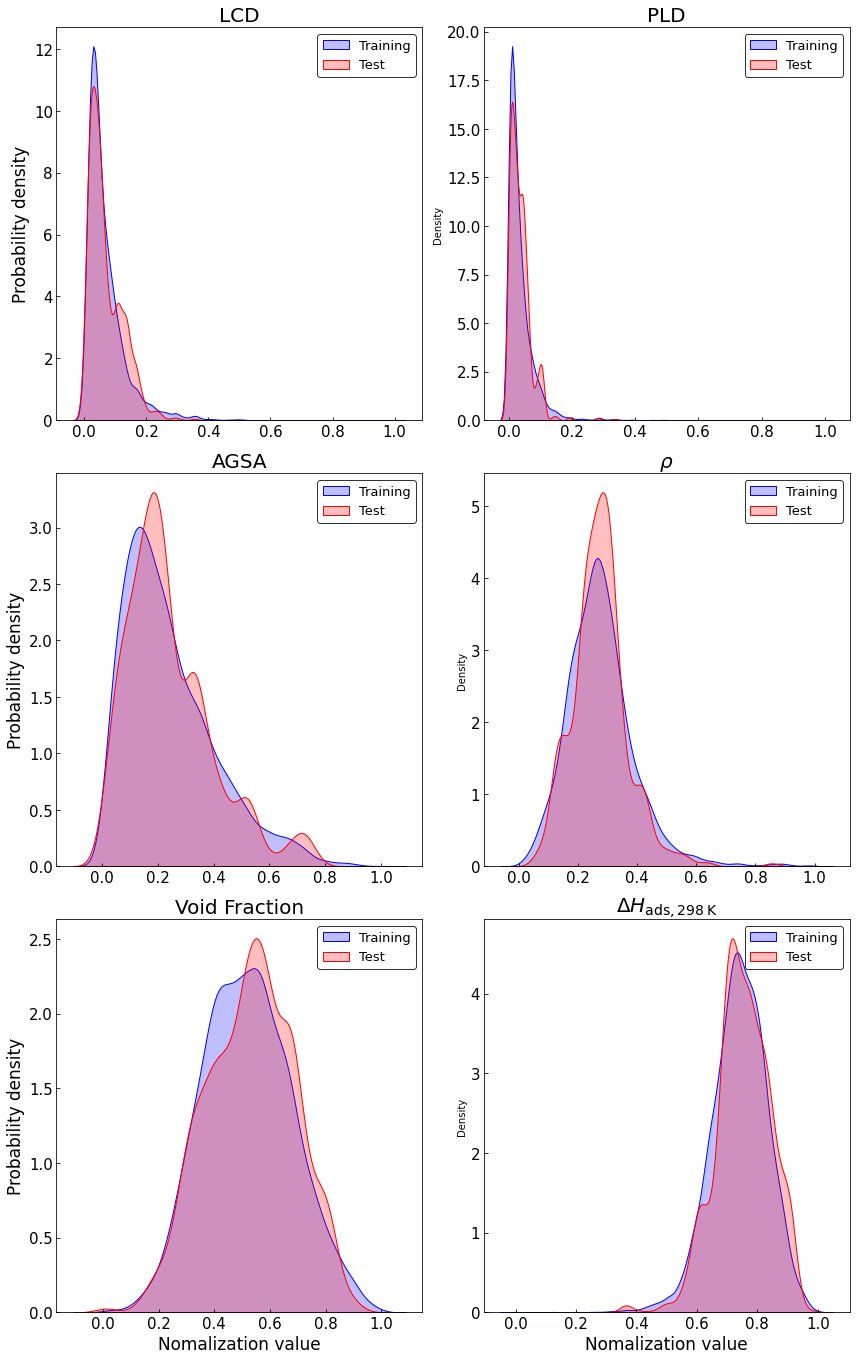

In [5]:

feature_0 = data.T[0]
feature_1 = data.T[1]
feature_2 = data.T[2]
feature_3 = data.T[3]
feature_4 = data.T[4]
feature_5 = data.T[5]
# rescale
feature_0 = (feature_0 - np.min(feature_0))/(np.max(feature_0) - np.min(feature_0))
feature_1 = (feature_1 - np.min(feature_1))/(np.max(feature_1) - np.min(feature_1))
feature_2 = (feature_2 - np.min(feature_2))/(np.max(feature_2) - np.min(feature_2))
feature_3 = (feature_3 - np.min(feature_3))/(np.max(feature_3) - np.min(feature_3))
feature_4 = (feature_4 - np.min(feature_4))/(np.max(feature_4) - np.min(feature_4))
feature_5 = (feature_5 - np.min(feature_5))/(np.max(feature_5) - np.min(feature_5))
if N_features == 5:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials)))
if N_features == 6:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials)))
if N_features == 7:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials),feature_6.reshape(1,N_materials)))
data=x.T
   
X_train = data[diverse_set]
X_test = data[remaining_set]

feature_list=['LCD', 'PLD', 'AGSA','$\mathit{\u03C1}$',  'Void Fraction',r'$\Delta\mathit{H}_{\mathrm{ads,298}}$$_{ }$$_{ }$$_{ }$$_\mathrm{ K}$']
fig=plt.figure(figsize=(12,19))
for i in range(feature_num):
    ax=plt.subplot(math.ceil(feature_num/2),2,i+1)
    if i%2==0:
        ax.set_ylabel("Probability density",fontsize=17)
    if i > 3 :
        ax.set_xlabel("Nomalization value",fontsize=17)
    ax.set_title(feature_list[i],fontsize=20,position=(.5,1.01))
    #for axis in ['top','bottom','left','right']:
    #ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=15)
    sns.distplot(list(X_train.T[i]),ax=ax, color='b',label="Training",hist=False,bins='scott',norm_hist=True, kde_kws={"shade": True})
    sns.distplot(list(X_test.T[i]),ax=ax, color='r',label="Test",hist=False,bins='scott',norm_hist=True, kde_kws={"shade": True})
    plt.legend(frameon=True,fontsize=13,edgecolor='k',loc='best')
plt.tight_layout()
plt.savefig("feature_distribution"+"_"+str(feature_num)+"_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+file_name+"_.png",dpi=400)

## 3.1 Train model(Gradient Boosting Regression)  and Save training model

In [32]:
importances_list=[]


for j,case in enumerate(cases):
    ### Load target ###
    with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        target = np.empty((N_samples,len(cases)))
        temp = next(data_file) 
        for i, d in enumerate(data_file):
            target[i] = np.asarray(d[feature_num:], dtype=np.float64)
    
    y_train = target[diverse_set].T
    y_test = target[remaining_set].T
    ### Hyperparameter tuning ###

    reg = GradientBoostingRegressor(max_features='sqrt',random_state=40)
    space  = [Integer(1,1000, name='n_estimators'),
            Integer(1, 5, name='max_depth'),
             Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
             Integer(2, 100, name='min_samples_split'),
             Integer(1, 100, name='min_samples_leaf')]
    @use_named_args(space)
    
    def objective(**params):
        
        reg.set_params(**params)   
        
        return -np.mean(cross_val_score(reg, X_train, y_train[j], cv=5, n_jobs=-1,
                                            scoring="neg_mean_absolute_error"))
    
    res_gp = gp_minimize(objective, space, n_calls=100, random_state=40)
    
    print(case)
    print("Best score=%.4f" % res_gp.fun)
    print("""Best parameters:
        - n_estimator=%d
        - max_depth=%d
        - learning_rate=%.6f
        - min_samples_split=%d
        - min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                                    res_gp.x[2], res_gp.x[3],
                                    res_gp.x[4]))
    reg_opt = GradientBoostingRegressor(n_estimators=res_gp.x[0],
                                            max_depth=res_gp.x[1],
                                           learning_rate=res_gp.x[2],
                                           min_samples_split=res_gp.x[3],
                                           min_samples_leaf=res_gp.x[4],
                                           random_state=40,
                                           max_features='sqrt')
    reg_opt.fit(X_train, y_train[j])
    save_model = joblib.dump(reg_opt,"Methane_" + case + "_" + str(feature_num) + "_" + str(diverse_ratio) + "_" + str("%.1f"%remaining_ratio) +"_"+file_name+".pkl")
    print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train[j]),reg_opt.score(X_test, y_test[j])))
    print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train[j],reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test[j],reg_opt.predict(X_test)))))
    print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train[j],reg_opt.predict(X_train)),mean_absolute_error(y_test[j],reg_opt.predict(X_test))))
    print([feature+" : "+str(reg_opt.feature_importances_[i]) for i,feature in enumerate(feature_list)])
    importances_list.append(list(reg_opt.feature_importances_))
    

LNG_ANG
Best score=16.2862
Best parameters:
        - n_estimator=1000
        - max_depth=5
        - learning_rate=0.019230
        - min_samples_split=2
        - min_samples_leaf=1
R^2 Training Score: 0.977 
R^2 Testing Score: 0.969
RMSE Training Score: 14.451 
RMSE Testing Score: 17.839
MAE Training Score: 10.931 
MAE Testing Score: 12.796
['LCD : 0.12157379133902325', 'PLD : 0.020442802777412363', 'AGSA : 0.3038568325870519', 'Density : 0.12250764924509717', 'VF : 0.262255099167804', 'dH : 0.16936382488361135']
ANG
Best score=8.7603
Best parameters:
        - n_estimator=1000
        - max_depth=5
        - learning_rate=0.033962
        - min_samples_split=2
        - min_samples_leaf=1
R^2 Training Score: 0.984 
R^2 Testing Score: 0.979
RMSE Training Score: 6.338 
RMSE Testing Score: 7.805
MAE Training Score: 4.875 
MAE Testing Score: 6.023
['LCD : 0.1305000195780682', 'PLD : 0.020474421268506626', 'AGSA : 0.36294660764262876', 'Density : 0.09872183948417916', 'VF : 0.224988561

## 3.2 Load feature importance from saved model

In [7]:
importances_list=[]
for case in cases:
    reg_opt= joblib.load("Methane_" + case + "_" + str(feature_num) + "_" + str(diverse_ratio) + "_" + str("%.1f"%remaining_ratio) +"_"+file_name+".pkl") 
    importances_list.append(list(reg_opt.feature_importances_))
print("Complete!")

C:\Users\Anivia\Anaconda3\envs\Test_main\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Anivia\Anaconda3\envs\Test_main\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Anivia\Anaconda3\envs\Test_main\lib\site-packages\sklearn\base.py:313: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from ve

Complete!


## 3.3 Plot feature importances

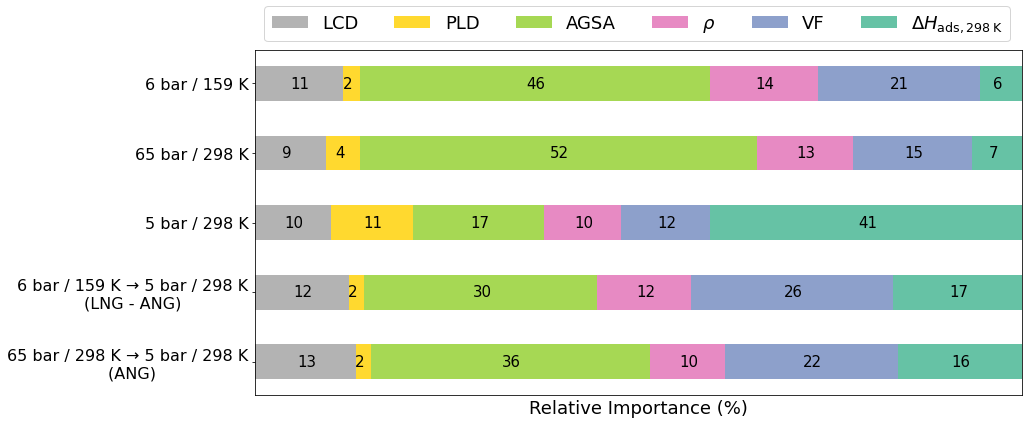

In [26]:
#6features
importances_list = [importances_list[3],importances_list[4],importances_list[2],importances_list[0],importances_list[1]]
titles=['6 bar / 159 K','65 bar / 298 K','5 bar / 298 K','6 bar / 159 K → 5 bar / 298 K\n(LNG - ANG)             ','65 bar / 298 K → 5 bar / 298 K\n(ANG)                  ']
features_6 = ['LCD', 'PLD',  'AGSA','$\mathit{\u03C1}$', 'VF',r'$\Delta\mathit{H}_{\mathrm{ads,298}}$$_{ }$$_{ }$$_{ }$$_\mathrm{ K}$']
color_map='Set2_r'
fig, ax = plt.subplots(figsize=(14.4,6))

ax.invert_yaxis()
ax.set_xticks([])
ax.tick_params(axis='x', which='both', direction='out',width=0)
category_colors = plt.get_cmap(color_map)(np.linspace(0.1,0.9,feature_num))
importances_list_remake=np.array(importances_list)
ax.set_xlim(0, np.sum(importances_list_remake, axis=1).max())
ax.set_xlabel("Relative Importance (%)",size=18)
for i ,(feature,color) in enumerate(zip(features_6,category_colors)):
    widths = importances_list_remake[:,i]
    starts = importances_list_remake.cumsum(axis=1)[:,i] - widths
    ax.barh(titles,importances_list_remake[:,i],left=starts, height =0.5,
        label=feature,color=color)
    xcenters = starts + widths / 2 - 0.011
    g,r,b,_=color
    text_color='k'
    for y,(x,c) in enumerate(zip(xcenters,widths)):
        ax.text(x,y,str(round(float(c*100))),ha='left',va='center',color=text_color,fontsize=15)    
    ax.legend(ncol=len(features_6),bbox_to_anchor=(0,1),
                loc='lower left', fontsize=18)
ax.tick_params(direction='out',labelsize=16)
plt.tight_layout()
plt.savefig('./GBR_'+str(diverse_ratio)+'_'+str("%.1f"%remaining_ratio)+'_'+str(feature_num)+'feature_'+file_name+'.png',dpi=600)
plt.show()
